In [1]:
# Copyright 2024 NASA
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rice mapping in Bhutan with U-Net using high resolution satellite imagery

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/SERVIR/servir-aces/blob/main/notebooks/aces_rice_classification_paro_2021.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/SERVIR/servir-aces/blob/main/notebooks/aces_rice_classification_paro_2021.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
</table>



This notebook is also available in this github repo: https://github.com/SERVIR/servir-aces. Navigate to the `notebooks` folder.

## Setup environment

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install servir-aces

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 40.9 M

In [4]:
!git clone https://github.com/SERVIR/servir-aces

Cloning into 'servir-aces'...
remote: Enumerating objects: 671, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 671 (delta 42), reused 69 (delta 38), pack-reused 572
Receiving objects: 100% (671/671), 2.33 MiB | 1.37 MiB/s, done.
Resolving deltas: 100% (419/419), done.


### Download datasets

For this chapter, we have already prepared and exported the training datasets. They can be found at the google cloud storage and we will use `gsutil` to get the dataset in our workspace. The dataset has `training`, `testing`, and `validation` subdirectory. Let's start by downloading these datasets in our workspace.

In [5]:
!mkdir /content/datasets

In [6]:
!gsutil -m cp -r gs://dl-book/chapter-1/* /content/datasets

Copying gs://dl-book/chapter-1/dnn_planet_wo_indices/training/training.tfrecord.gz...
Copying gs://dl-book/chapter-1/dnn_planet_wo_indices/testing/testing.tfrecord.gz...
Copying gs://dl-book/chapter-1/.DS_Store...
Copying gs://dl-book/chapter-1/dnn_planet_wo_indices/validation/validation.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100002.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100003.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100001.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100004.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100000.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_202100005.tfrecord.gz...
Copying gs://dl-book/chapter-1/images/image_2021mixer.json...
Copying gs://dl-book/chapter-1/prediction/prediction_dnn_v1.TFRecord...
Copying gs://dl-book/chapter-1/prediction/prediction_unet_v1.TFRecord...
Copying gs://dl-book/chapter-1/unet_256x256_planet_wo_indices/testing/testi

### Setup config file variables

Now the repo is downloaded. We will create an environment file file to place point to our training data and customize parameters for the model. To do this, we make a copy of the `.env.example` file provided.

Under the hood, all the configuration provided via the environment file are parsed as a config object and can be accessed programatically.

Note current version does not expose all the model intracacies through the environment file but future version may include those depending on the need.

In [7]:
!cp servir-aces/.env.example servir-aces/config.env

Okay, now we have the `config.env` file, we will use this to provide our environments and parameters.

Note there are several parameters that can be changed. Let's start by changing the `BASEDIR` and `OUTPUT_DIR` as below.

```
BASEDIR = "/content/"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output"
```

We will start by training a [U-Net](https://insert-citation-here) model using the `dl-book/chapter-1/unet_256x256_planet_wo_indices` dataset inside the `dataset` folder for this exercise. Let's go ahead and change our DATADIR in the `config.env` file as below.

```
DATADIR = "datasets/unet_256x256_planet_wo_indices"
```

These datasets have RGBN from Planetscope mosiac. Since we are trying to map the rice fields, we use growing season and pre-growing season information. Thus, we have 8 optical bands, namely `red_before`, `green_before`, `blue_before`, `nir_before`, `red_during`, `green_during`, `blue_during`, and  `nir_during`. In adidition, you can use `USE_ELEVATION` and `USE_S1` config to include the topographic and radar information. Since this datasets have toppgraphic and radar features, so we won't be settting these config values. Similarly, these datasets are tiled to 256x256 pixels, so let's also change that.

```
# For model training, USE_ELEVATION extends FEATURES with "elevation" & "slope"
# USE_S1 extends FEATURES with "vv_asc_before", "vh_asc_before", "vv_asc_during", "vh_asc_during",
# "vv_desc_before", "vh_desc_before", "vv_desc_during", "vh_desc_during"
# In case these are not useful and you have other bands in your training data, you can do set
# USE_ELEVATION and USE_S1 to False and update FEATURES to include needed bands
USE_ELEVATION = False
USE_S1 = False

PATCH_SHAPE = (256, 256)
```

Next, we need to calculate the size of the traiing, testing and validation dataset. For this, we know our size before hand. But `aces` also provides handful of functions that we can use to calculate this. See this [notebook](https://colab.research.google.com/drive/12WgDI3ptFZHmcfOw89fmPSsDwO-sXIUH?usp=sharing) to learn more about how to do it. We will also change the `BATCH_SIZE` to 32; if you have larger memory available, you can increase the `BATCH_SIZE`. You can run for longer `EPOCHS` by changing the `EPOCHS` paramter; we will keep it to 5 for now.

```
# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 8531
TEST_SIZE = 1222
VAL_SIZE = 2404
BATCH_SIZE = 32
EPOCHS = 30
```

### Update the config file programtically

We can also make a dictionary so we can change these config settings programatically.

In [8]:
BASEDIR   = "/content/" # @param {type:"string"}
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output" # @param {type:"string"}
DATADIR = "datasets/unet_256x256_planet_wo_indices" # @param {type:"string"}
# PATCH_SHAPE, USE_ELEVATION, USE_S1, TRAIN_SIZE, TEST_SIZE, VAL_SIZE
# BATCH_SIZE, EPOCHS are converted to their appropriate type.
USE_ELEVATION = "False" # @param {type:"string"}
USE_S1 = "False" # @param {type:"string"}
PATCH_SHAPE = "(256, 256)" # @param {type:"string"}
TRAIN_SIZE = "8531" # @param {type:"string"}
TEST_SIZE = "1222" # @param {type:"string"}
VAL_SIZE = "2404" # @param {type:"string"}
BATCH_SIZE = "32" # @param {type:"string"}
EPOCHS = "30" # @param {type:"string"}
MODEL_DIR_NAME = "unet_v1" # @param {type:"string"}

In [9]:
unet_config_settings = {
    "BASEDIR" : BASEDIR,
    "OUTPUT_DIR": OUTPUT_DIR,
    "DATADIR": DATADIR,
    "USE_ELEVATION": USE_ELEVATION,
    "USE_S1": USE_S1,
    "PATCH_SHAPE": PATCH_SHAPE,
    "TRAIN_SIZE": TRAIN_SIZE,
    "TEST_SIZE": TEST_SIZE,
    "VAL_SIZE": VAL_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "MODEL_DIR_NAME": MODEL_DIR_NAME,
}


In [10]:
import dotenv

config_file = "servir-aces/config.env"

for config_key in unet_config_settings:
    dotenv.set_key(dotenv_path=config_file,
                   key_to_set=config_key,
                   value_to_set=unet_config_settings[config_key]
                   )

## U-Net Model

### Load config file variables

In [11]:
from aces import Config, DataProcessor, ModelTrainer, EEUtils


Let's load our config file through the `Config` class.

In [12]:
unet_config = Config(config_file=config_file)

BASEDIR: /content
DATADIR: /content/datasets/unet_256x256_planet_wo_indices
using features: ['red_before', 'green_before', 'blue_before', 'nir_before', 'red_during', 'green_during', 'blue_during', 'nir_during']
using labels: ['class']


Most of the config in the `config.env` is now available via the config instance. Let's check few of them here.

In [13]:
unet_config.TRAINING_DIR, unet_config.OUTPUT_DIR, unet_config.BATCH_SIZE, unet_config.TRAIN_SIZE

(PosixPath('/content/datasets/unet_256x256_planet_wo_indices/training'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output'),
 32,
 8531)

### Load `ModelTrainer` class

Next, let's make an instance of the `ModelTrainer` object. The `ModelTrainer` class provides various tools for training, buidling, compiling, and running specified deep learning models.



In [14]:
unet_model_trainer = ModelTrainer(unet_config, seed=42)


Using seed: 42


### Train and Save U-Net model

[`ModelTrainer`](https://servir.github.io/servir-aces/model_trainer/) class provides various functionality. We will use `train_model` function that helps to train the model using the provided configuration settings.

This method performs the following steps:
- Configures memory growth for TensorFlow.
- Creates TensorFlow datasets for training, testing, and validation.
- Builds and compiles the model.
- Prepares the output directory for saving models and results.
- Starts the training process.
- Evaluates and prints validation metrics.
- Saves training parameters, plots, and models.

****************************************************************************
****************************** Clear Session... ****************************
****************************************************************************
****************************** Configure memory growth... ************************
 > Found 1 GPUs
****************************************************************************
****************************** creating datasets... ************************
Loading dataset from /content/datasets/unet_256x256_planet_wo_indices/training/*
randomly transforming data
Loading dataset from /content/datasets/unet_256x256_planet_wo_indices/validation/*
Loading dataset from /content/datasets/unet_256x256_planet_wo_indices/testing/*
Printing dataset info:
Training
inputs: float32 (32, 256, 256, 8)
tf.Tensor(
[[[[0.073075 0.063275 0.0411   ... 0.050625 0.0274   0.23925 ]
   [0.084775 0.067375 0.047025 ... 0.057675 0.032075 0.242375]
   [0.083625 0.068575 0.045075 ... 0.05927

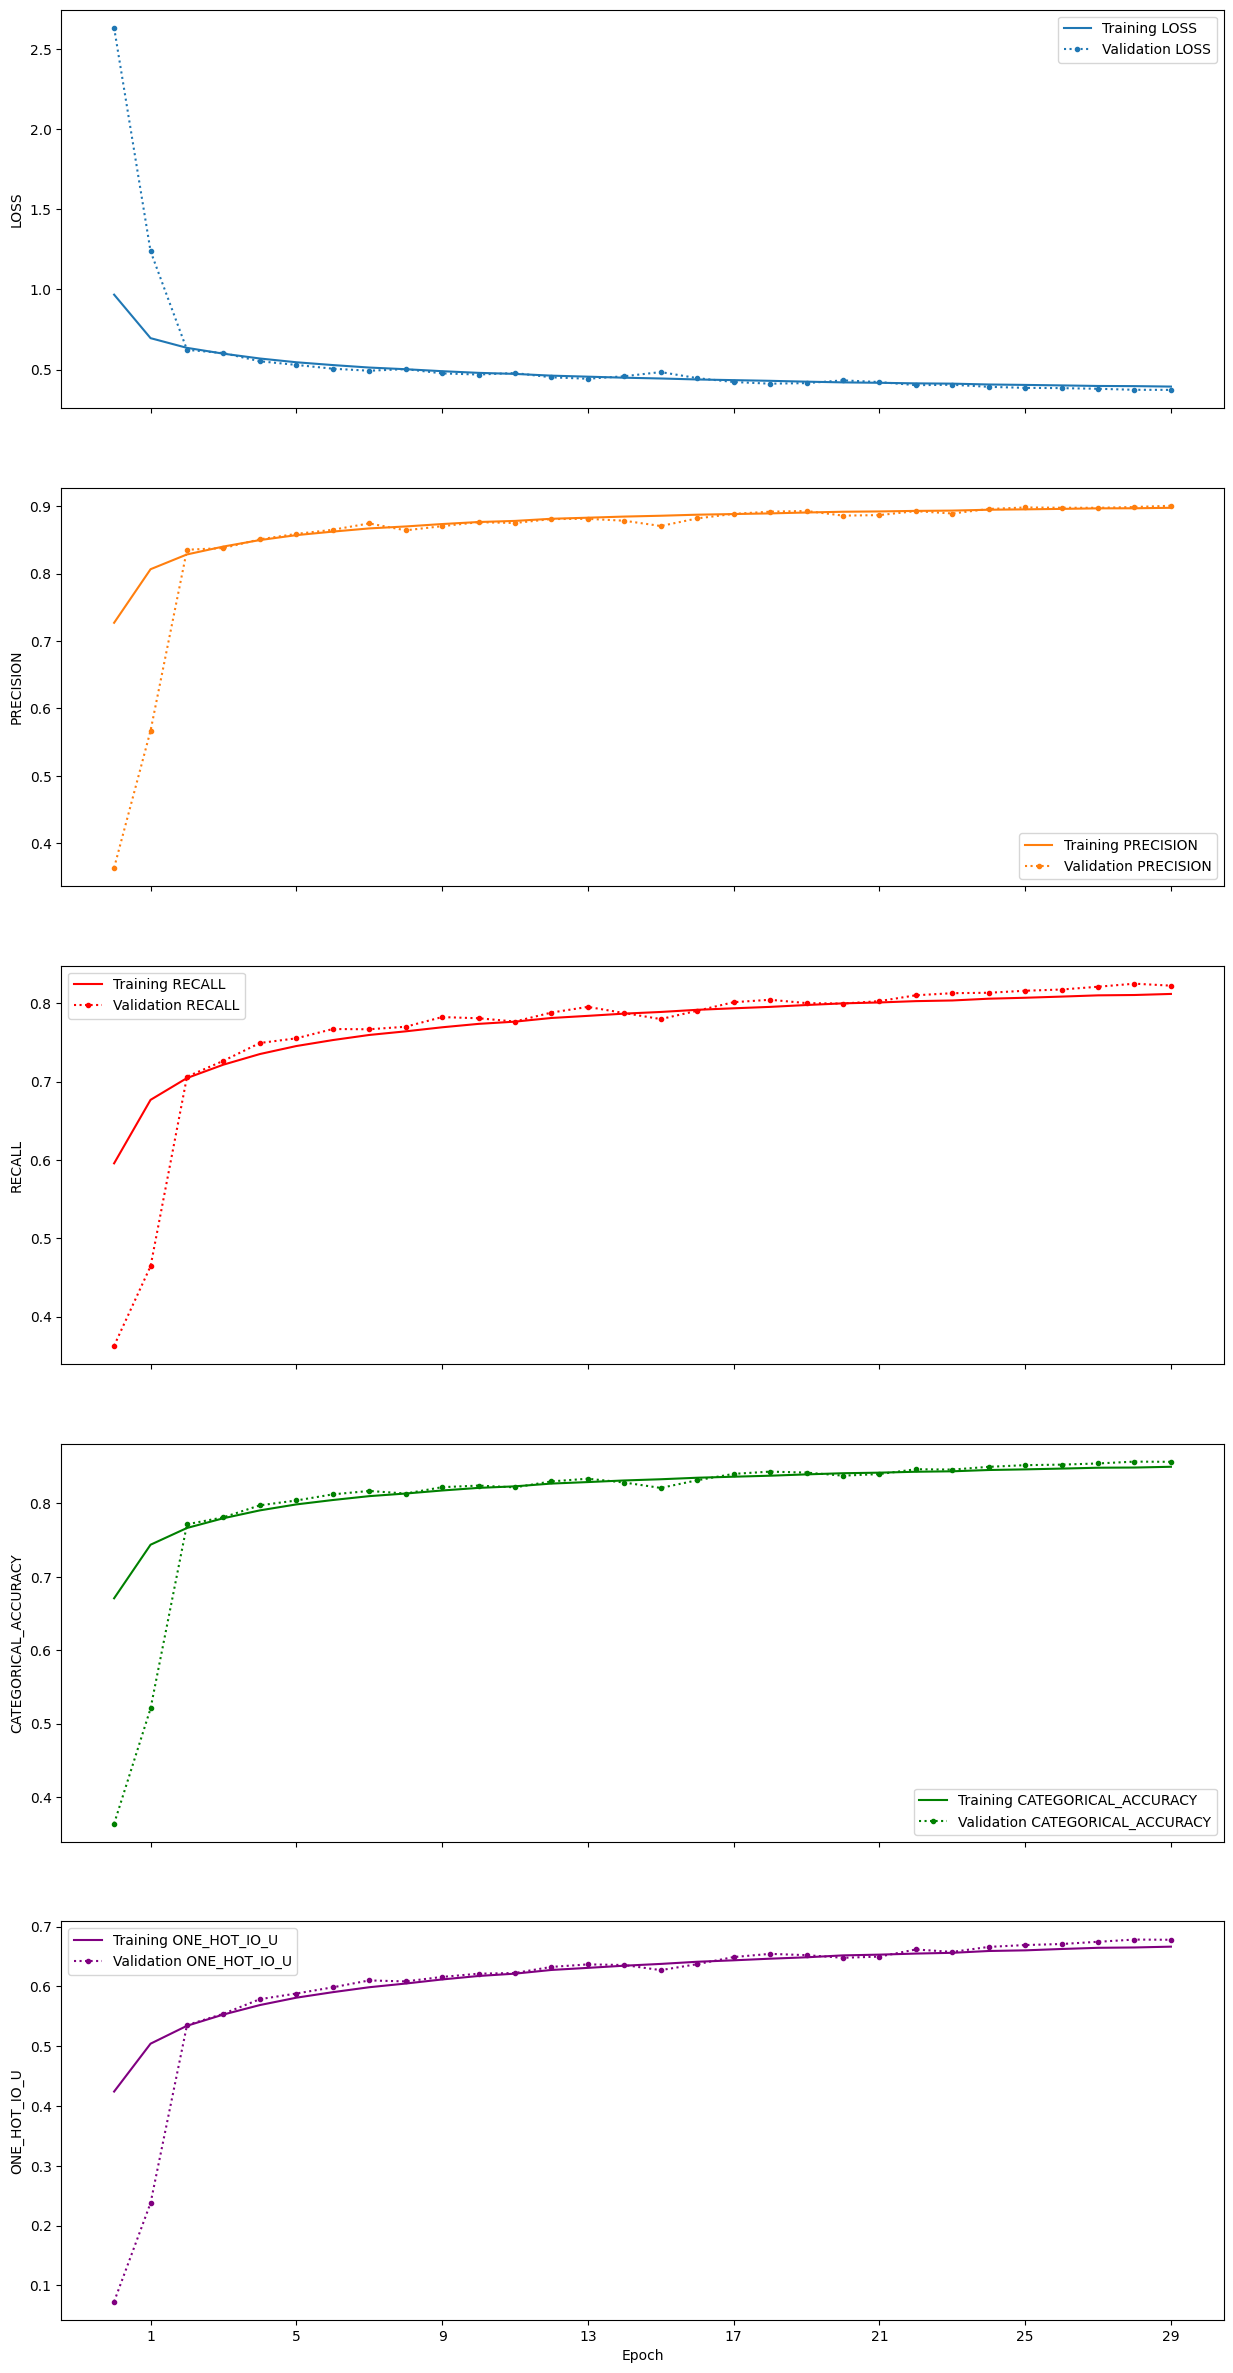

In [ ]:
unet_model_trainer.train_model()

### Save the config file

In [ ]:
from pathlib import Path
import shutil

config_file = Path(config_file)
drive_config_file = Path(unet_config.MODEL_DIR / f"{str(config_file).split('/')[-1]}")

# Create the target directory if it doesn't exist
drive_config_file.parent.mkdir(parents=True, exist_ok=True)

# Copy the file
shutil.copy(config_file, drive_config_file)

print(f"File copied from {config_file} to {drive_config_file}")

File copied from servir-aces/config.env to /content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output/unet_v1/config.env


### Load the Saved U-Net Model

Load the saved model

In [15]:
import tensorflow as tf

In [16]:
unet_model = tf.keras.models.load_model(f"{str(unet_config.MODEL_DIR)}/trained-model")

In [17]:
print(unet_model.summary())

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 8)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       2336      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0]

### Inference using Saved U-Net Model

Now we can use the saved model to start the export of the prediction of the image. For prediction, you would need to first prepare your image data. We have already exported the image needed here, which we will use for now. See [this notebook](https://colab.research.google.com/drive/1MZexam3GZKsQySQO9Jk_RPNyyMLmciEq?usp=sharing) to understand how we did it.

In addition, [this notebook](https://colab.research.google.com/drive/19AZ-I7YrGNSsWkqbzjNLw3MXVeV4N2uX?usp=sharing) shows how you can then use the image to predict from the saved Model.

In any case, you now have the prediction in the Earth Engine as image.

## DNN Model

### Setup any changes in the config file for DNN Model

There are few config variables that needs to be changed for running a DNN model. First would be the data itself so let's change the `DATADIR`. We also need to change our output directory using `MODEL_DIR_NAME`. This is the sub-directory inside the `OUTPUT_DIR` for this model run. We also need to specify this is the DNN model that we want to run. We have `MODEL_TYPE` parameter for that. Currently, it supports unet, dnn, and cnn (case sensitive) models; default being unet. Make other changes, as appropriate.

```
DATADIR = "datasets/dnn_planet_wo_indices"
MODEL_DIR_NAME = "dnn_v1"
MODEL_TYPE = "dnn"
```

### Update the config file programtically

In [18]:
DATADIR = "datasets/dnn_planet_wo_indices" # @param {type:"string"}
# PATCH_SHAPE, USE_ELEVATION, USE_S1, TRAIN_SIZE, TEST_SIZE, VAL_SIZE
# BATCH_SIZE, EPOCHS are converted to their appropriate type.
MODEL_DIR_NAME = "dnn_v1" # @param {type:"string"}
MODEL_TYPE = "dnn" # @param {type:"string"}
BATCH_SIZE = "32" # @param {type:"string"}
EPOCHS = "30" # @param {type:"string"}


In [19]:
dnn_config_settings = {
    "DATADIR": DATADIR,
    "MODEL_DIR_NAME": MODEL_DIR_NAME,
    "MODEL_TYPE": MODEL_TYPE,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
}


In [20]:
for config_key in dnn_config_settings:
    dotenv.set_key(dotenv_path=config_file,
                   key_to_set=config_key,
                   value_to_set=dnn_config_settings[config_key]
                   )

### Load config file variables for DNN Model

In [22]:
dnn_config = Config(config_file=config_file, override=True)

BASEDIR: /content
DATADIR: /content/datasets/dnn_planet_wo_indices
using features: ['red_before', 'green_before', 'blue_before', 'nir_before', 'red_during', 'green_during', 'blue_during', 'nir_during']
using labels: ['class']


Most of the config in the `config.env` is now available via the config instance. Let's check few of them here.

In [23]:
dnn_config.TRAINING_DIR, dnn_config.OUTPUT_DIR, dnn_config.BATCH_SIZE, dnn_config.MODEL_TYPE

(PosixPath('/content/datasets/dnn_planet_wo_indices/training'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output'),
 32,
 'dnn')

### Load `ModelTrainer` class

Next, let's make an instance of the `ModelTrainer` object. The `ModelTrainer` class provides various tools for training, buidling, compiling, and running specified deep learning models.


In [24]:
dnn_model_trainer = ModelTrainer(dnn_config, seed=42)

Using seed: 42


### Train and Save DNN model

****************************************************************************
****************************** Clear Session... ****************************
****************************************************************************
****************************** Configure memory growth... ************************
 > Found 1 GPUs
****************************************************************************
****************************** creating datasets... ************************
Loading dataset from /content/datasets/dnn_planet_wo_indices/training/*
Loading dataset from /content/datasets/dnn_planet_wo_indices/validation/*
Loading dataset from /content/datasets/dnn_planet_wo_indices/testing/*
Printing dataset info:
Training
inputs: float32 (32, 1, 8)
tf.Tensor(
[[[0.06445  0.0383   0.09815  0.06755  0.269975 0.207325 0.11135
   0.060025]]

 [[0.075925 0.02705  0.08695  0.054775 0.235575 0.291625 0.1049
   0.0364  ]]

 [[0.043625 0.025    0.064175 0.04265  0.22     0.225    0.062025
   0

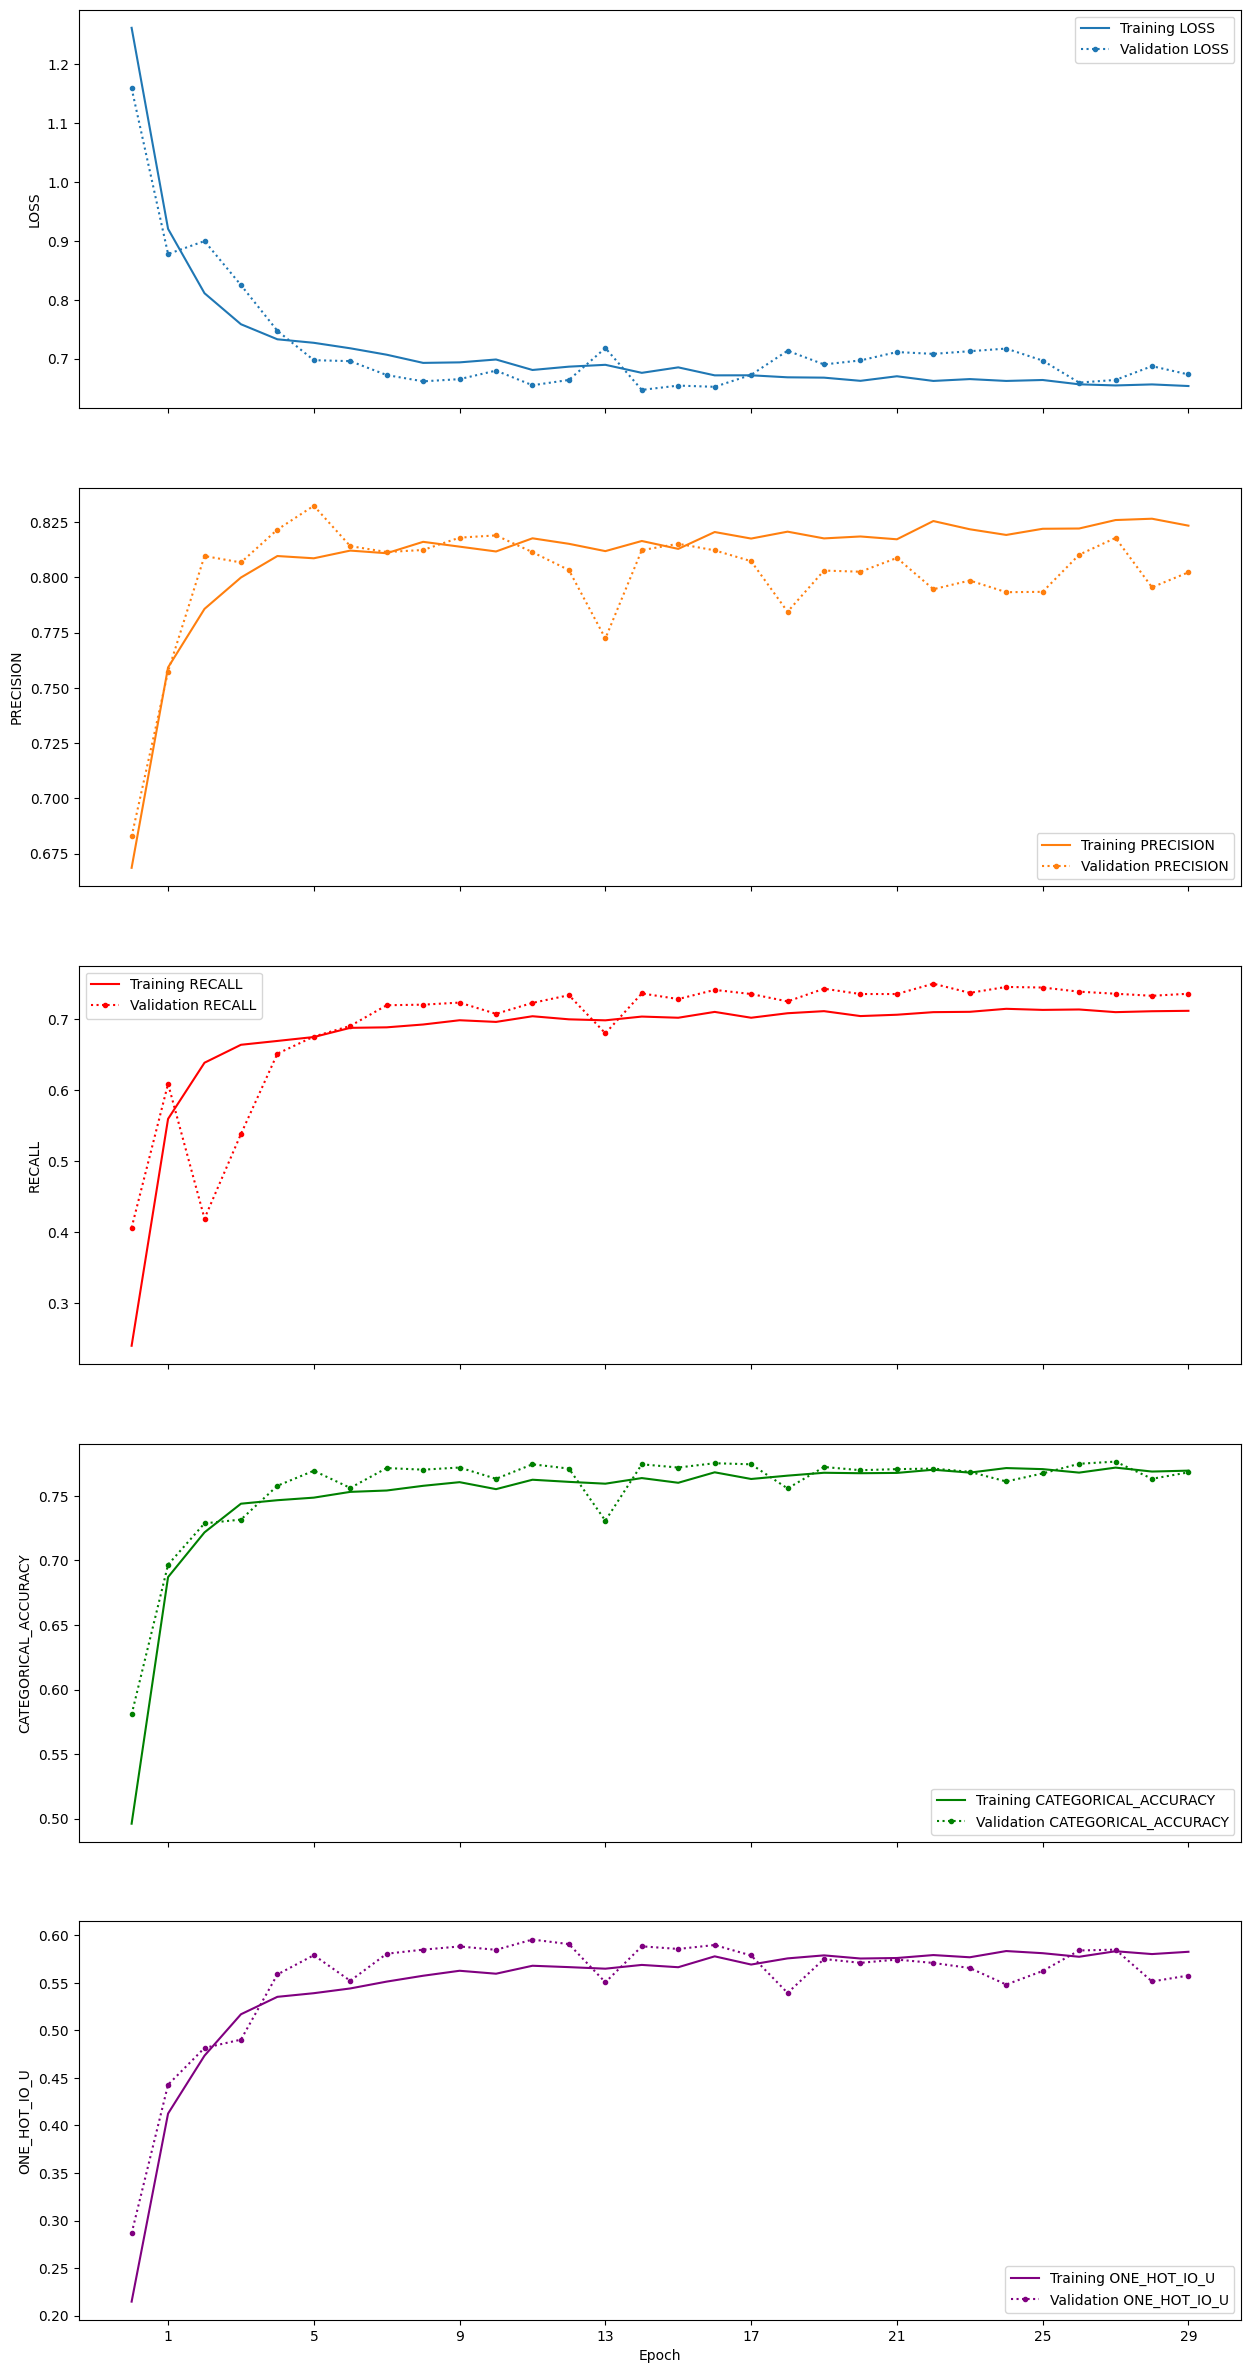

In [ ]:
dnn_model_trainer.train_model()

### Save the config file

In [ ]:
drive_config_file = Path(dnn_config.MODEL_DIR / f"{str(config_file).split('/')[-1]}")

# Create the target directory if it doesn't exist
drive_config_file.parent.mkdir(parents=True, exist_ok=True)

# Copy the file
shutil.copy(config_file, drive_config_file)

print(f"File copied from {config_file} to {drive_config_file}")

File copied from servir-aces/config.env to /content/drive/MyDrive/Colab Notebooks/DL_Book/Chapter_1/output/dnn_v1/config.env


### Load the Saved DNN Model

In [25]:
dnn_model = tf.keras.models.load_model(f"{str(dnn_config.MODEL_DIR)}/trained-model")


In [26]:
print(dnn_model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 8)]         0         
                                                                 
 dense (Dense)               (None, None, 256)         2304      
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_2 (Dense)             (None, None, 64)          8256      
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0     

### Inference using Saved DNN Model

Now we can use the saved model to start the export of the prediction of the image. For prediction, you would need to first prepare your image data. We have already exported the image needed here, which we will use for now. See [this notebook](https://colab.research.google.com/drive/1MZexam3GZKsQySQO9Jk_RPNyyMLmciEq?usp=sharing) to understand how we did it.

In addition, [this notebook](https://colab.research.google.com/drive/1c59eWgw637n1aQfyIobOKIIulqKSXeqv?usp=sharing) shows how you can then use the image to predict from the saved Model.

In any case, you now have the prediction in the Earth Engine as image.

## Independent Validation

For independent validation, we will use a file that we have prepared. These files were collected using [Collect Earth Online](https://app.collect.earth/home) by SCO and NASA DEVELOP interns. We will be using GEE here. Before we do that, let's make changes in our config file.

We will make sure our `GCS_PROJECT` is setup correctly.

```
GCS_PROJECT = "servir-ee"
```

### Update the config file

In [27]:
GCS_PROJECT = "servir-ee" # @param {type:"string"}


In [28]:
config_settings = {
    "GCS_PROJECT": GCS_PROJECT,
}


In [29]:
for config_key in config_settings:
    dotenv.set_key(dotenv_path=config_file,
                   key_to_set=config_key,
                   value_to_set=config_settings[config_key]
                   )

### Load config file variable

In [30]:
config = Config(config_file=config_file, override=True)

BASEDIR: /content
DATADIR: /content/datasets/dnn_planet_wo_indices
using features: ['red_before', 'green_before', 'blue_before', 'nir_before', 'red_during', 'green_during', 'blue_during', 'nir_during']
using labels: ['class']


### Import earthengine and geemap for visualization

In [31]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
# ee.Initialize(project=f"{config.GCS_PROJECT}")
EEUtils.initialize_session(use_highvolume=True, project=config.GCS_PROJECT)


In [32]:
import geemap

Map = geemap.Map()

### Class Information and Masking

In [33]:
# CLASS
# 0 - cropland etc.
# 1 - rice
# 2 - forest
# 3 - Built up
# 4 - Others (includes water body)
l1 = ee.FeatureCollection("projects/servir-sco-assets/assets/Bhutan/BT_Admin_1")
paro = l1.filter(ee.Filter.eq("ADM1_EN", "Paro"))


# mask the rice growing zone
# in Paro, rice grows upto 2600 m asl (double check to make sure??)
dem = ee.Image("MERIT/DEM/v1_0_3") # ee.Image('USGS/SRTMGL1_003')
dem = dem.clip(paro)
rice_zone = dem.gte(0).And(dem.lte(2600))


### Model: U-Net

#### Load and visualize the prediction output

In [34]:
UNET_RGBN = ee.Image("projects/servir-ee/assets/dl-book/chapter-1/prediction/prediction_unet_v1")
UNET_RGBN = UNET_RGBN.updateMask(rice_zone)
Map.centerObject(UNET_RGBN, 11)
Map.addLayer(UNET_RGBN.clip(paro), {"bands": ["prediction"], "min":0, "max":4, "palette": ["FFFF00", "FFC0CB", "267300", "E60000", "005CE6"]}, "UNET_RGBN")
Map

Map(center=[27.378354616518475, 89.42005508391453], controls=(WidgetControl(options=['position', 'transparent_…

#### Calculate classification metrics

Remapping to rice and non-rice output

In [35]:
UNET_RGBN_remapped = UNET_RGBN.remap([0, 1, 2, 3, 4], [0, 1, 0, 0, 0], 0, "prediction")
Map.addLayer(UNET_RGBN_remapped, {"min": 0, "max": 1, "palette": ["cfcf00", "267300"]}, "UNET_RGBN_remapped")
Map

Map(bottom=220961.0, center=[27.378354616518475, 89.42005508391453], controls=(WidgetControl(options=['positio…

In [36]:
sampling_geom = ee.FeatureCollection("projects/servir-ee/assets/dl-book/chapter-1/data/sampledGeom")
ceo_final_data = ee.FeatureCollection("projects/servir-ee/assets/dl-book/chapter-1/data/ceoData")
ceo_final_data = ee.FeatureCollection(ceo_final_data.filter(ee.Filter.bounds(sampling_geom).Not()))


In [37]:
prediction_unet = UNET_RGBN_remapped.sampleRegions(
    collection = ceo_final_data,
    scale = 10,
    geometries = True
)

# print("predictionOutputUnet", prediction_unet.getInfo())


In [38]:
error_matrix_unet = prediction_unet.errorMatrix(actual="rice", predicted="remapped")
test_acc_unet = error_matrix_unet.accuracy()
test_kappa_unet = error_matrix_unet.kappa()
test_recall_producer_acc_unet = error_matrix_unet.producersAccuracy().get([1, 0])
test_precision_consumer_acc_unet = error_matrix_unet.consumersAccuracy().get([0, 1])
f1_unet = error_matrix_unet.fscore().get([1])


In [39]:
print("error_matrix_unet", error_matrix_unet.getInfo())
print("test_acc_unet", test_acc_unet.getInfo())
print("test_kappa_unet", test_kappa_unet.getInfo())
print("test_recall_producer_acc_unet", test_recall_producer_acc_unet.getInfo())
print("test_precision_consumer_acc_unet", test_precision_consumer_acc_unet.getInfo())
print("f1_unet", f1_unet.getInfo())

error_matrix_unet [[1191, 29], [33, 50]]
test_acc_unet 0.9524174980813507
test_kappa_unet 0.5919321924312524
test_recall_producer_acc_unet 0.6024096385542169
test_precision_consumer_acc_unet 0.6329113924050633
f1_unet 0.6172839506172839


#### Calculate Probability Distribution

In [40]:
prob_output_unet = UNET_RGBN.select(["prediction", "others_etc", "cropland_etc", "urban", "forest", "rice"]) \
                            .rename(["prediction_class", "others_prob", "cropland_prob", "urban_prob", "forest_prob", "rice_prob"]) \
                            .sampleRegions(collection=ceo_final_data, scale=10, geometries=True)

# print("prob_output_unet", prob_output_unet.getInfo())


In [41]:
prob_output_unet = prob_output_unet.getInfo()

### Model: DNN

#### Load and visualize the prediction output

In [42]:
DNN_RGBN = ee.Image("projects/servir-ee/assets/dl-book/chapter-1/prediction/prediction_dnn_v1")
DNN_RGBN = DNN_RGBN.updateMask(rice_zone)
Map.centerObject(DNN_RGBN)
Map.addLayer(DNN_RGBN.clip(paro), {"bands": ["prediction"], "min":0, "max":4, "palette": ["FFFF00", "FFC0CB", "267300", "E60000", "005CE6"]}, "DNN_RGBN")
Map

Map(bottom=220961.0, center=[27.378354616518475, 89.42005508391453], controls=(WidgetControl(options=['positio…

#### Calculate classification metrics

In [43]:
DNN_RGBN_remapped = DNN_RGBN.remap([0, 1, 2, 3, 4], [0, 1, 0, 0, 0], 0, "prediction")
Map.addLayer(DNN_RGBN_remapped, {"min": 0, "max": 1, "palette": ["cfcf00", "267300"]}, "DNN_RGBN_remapped")
Map

Map(bottom=220961.0, center=[27.37845188654284, 89.42005507220328], controls=(WidgetControl(options=['position…

In [ ]:
prediction_dnn = DNN_RGBN_remapped.sampleRegions(
    collection = ceo_final_data,
    scale = 10,
    geometries = True
)

# print("predictionOutputDNN", prediction_dnn.getInfo())


In [45]:
error_matrix_dnn = prediction_dnn.errorMatrix(actual="rice", predicted="remapped")
test_acc_dnn = error_matrix_dnn.accuracy()
test_kappa_dnn = error_matrix_dnn.kappa()
test_recall_producer_acc_dnn = error_matrix_dnn.producersAccuracy().get([1, 0])
test_precision_consumer_acc_dnn = error_matrix_dnn.consumersAccuracy().get([0, 1])
f1_dnn = error_matrix_dnn.fscore().get([1])


In [46]:
print("error_matrix_dnn", error_matrix_dnn.getInfo())
print("test_acc_dnn", test_acc_dnn.getInfo())
print("test_kappa_dnn", test_kappa_dnn.getInfo())
print("test_recall_producer_acc_dnn", test_recall_producer_acc_dnn.getInfo())
print("test_precision_consumer_acc_dnn", test_precision_consumer_acc_dnn.getInfo())
print("f1_dnn", f1_dnn.getInfo())

error_matrix_dnn [[1175, 45], [20, 63]]
test_acc_dnn 0.9501151189562548
test_kappa_dnn 0.6332676611314382
test_recall_producer_acc_dnn 0.7590361445783133
test_precision_consumer_acc_dnn 0.5833333333333334
f1_dnn 0.6596858638743456


#### Calculate Probability Distribution

In [47]:
prob_output_dnn = DNN_RGBN.select(["prediction", "others_etc", "cropland_etc", "urban", "forest", "rice"]) \
                            .rename(["prediction_class", "others_prob", "cropland_prob", "urban_prob", "forest_prob", "rice_prob"]) \
                            .sampleRegions(collection=ceo_final_data, scale=10, geometries=True)

# print("prob_output_dnn", prob_output_dnn.getInfo())


In [48]:
prob_output_dnn = prob_output_dnn.getInfo()

## Figures and Plots

### Training and Validation Plot

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

%matplotlib inline

In [50]:
with open(unet_config.MODEL_DIR / "model.pkl", "rb") as f:
    unet_model_metrics = pickle.load(f)

with open(dnn_config.MODEL_DIR / "model.pkl", "rb") as f:
    dnn_model_metrics = pickle.load(f)


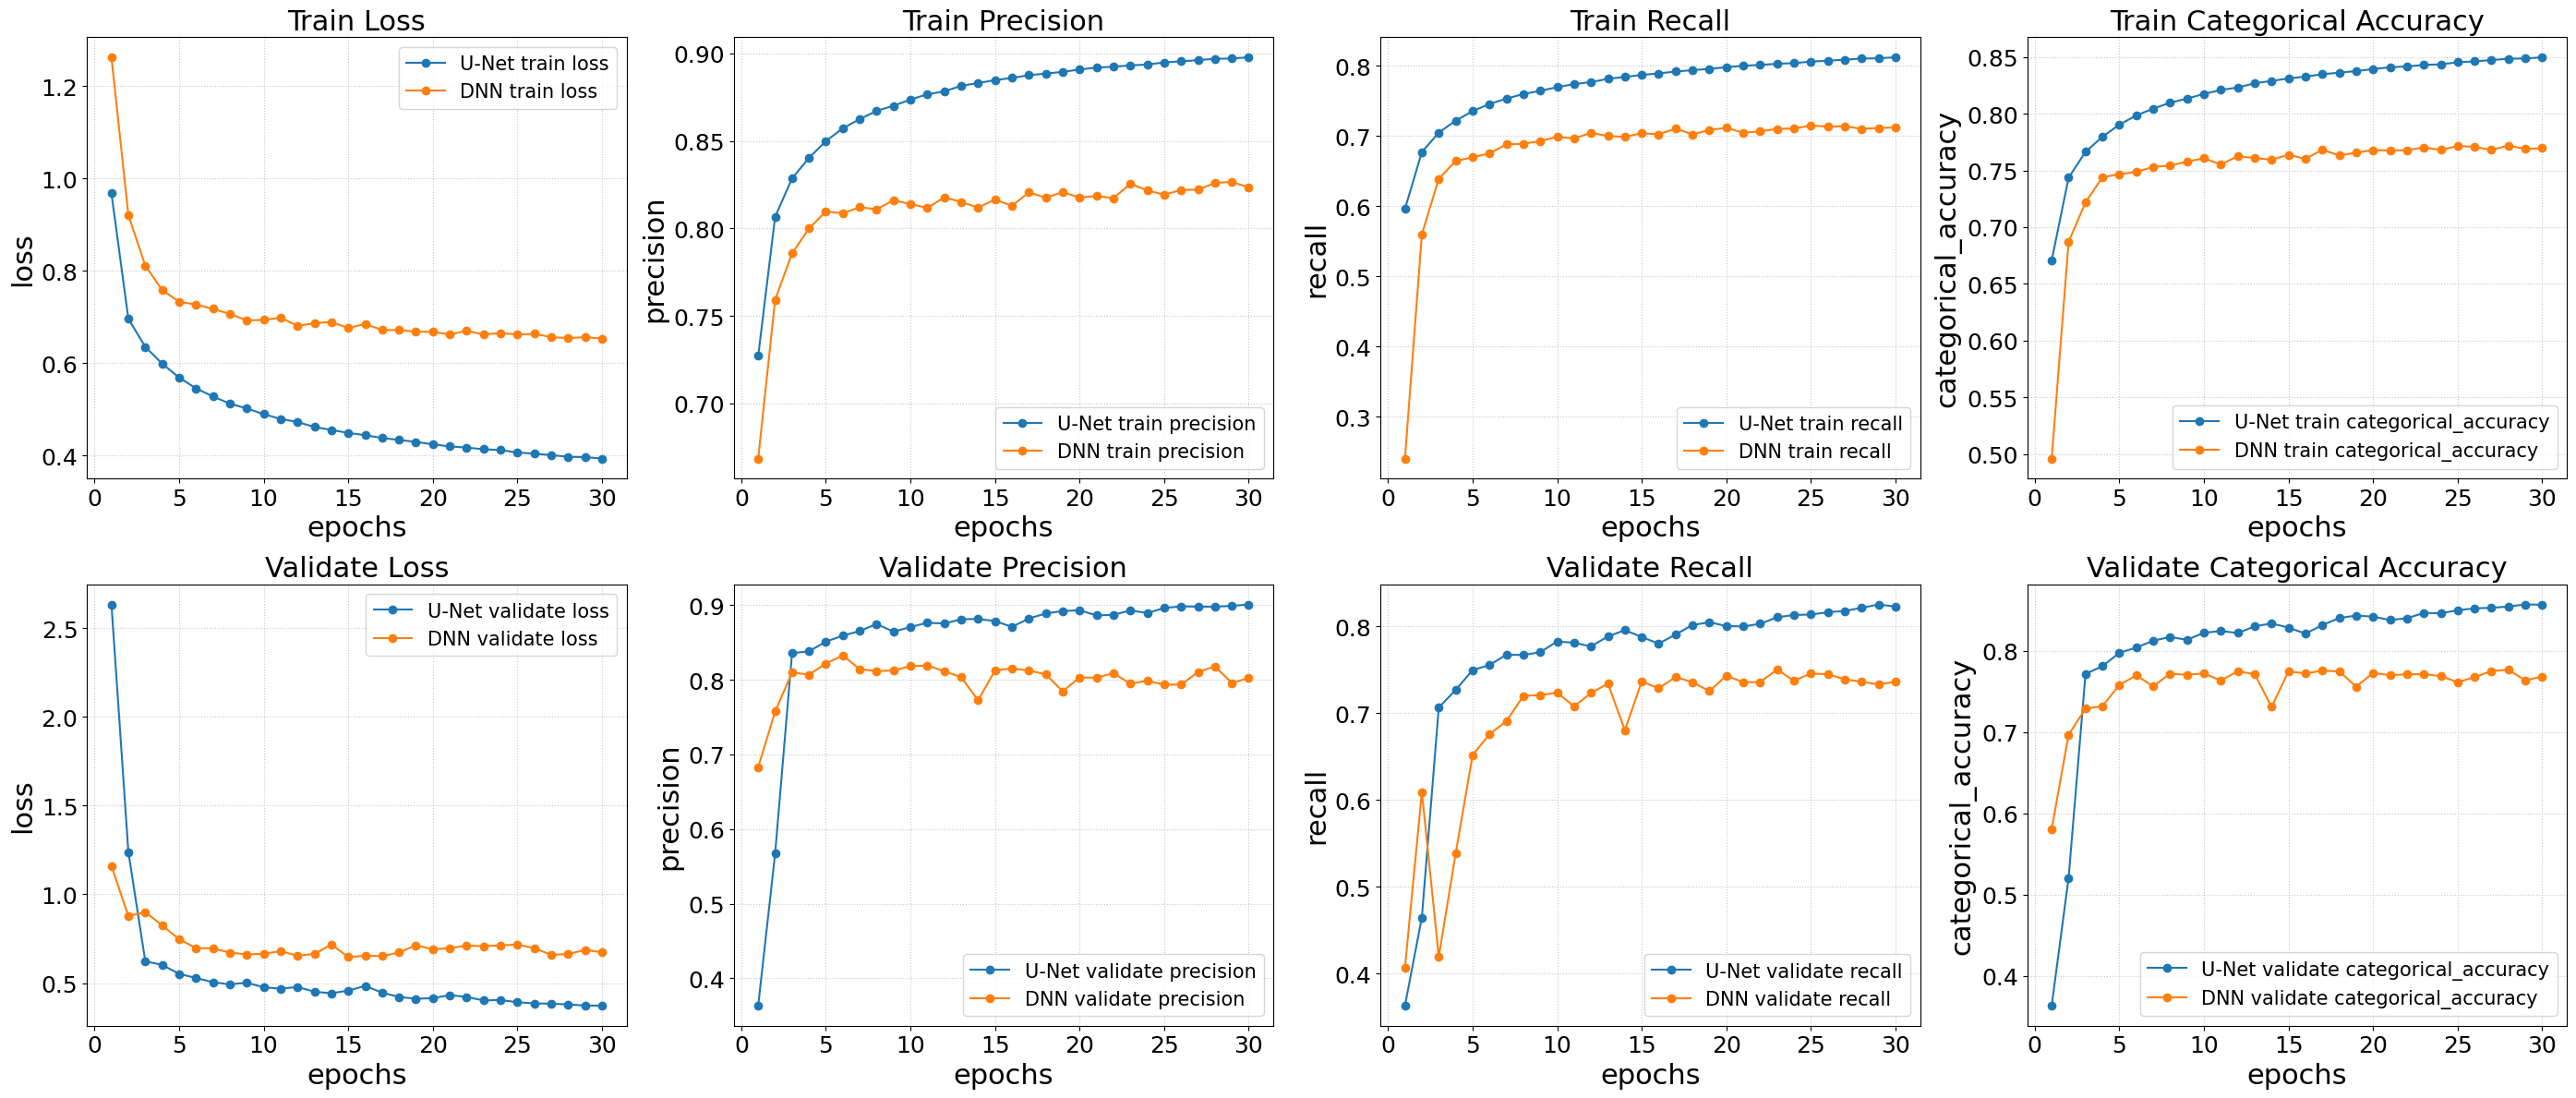

In [51]:
# Create subplots for different metrics in a 3x4 grid
fig, axs = plt.subplots(2, 4, figsize=(4*7, 6*2))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
metrics = ["loss", "precision", "recall", "categorical_accuracy"]
metrics_name = ["Loss", "Precision", "Recall", "Categorical Accuracy"]

epochs = range(1, config.EPOCHS + 1)

title_fontsize = 22
label_fontsize = 22
legend_fontsize = 15
tick_fontsize = 18
lw=1.5

for i in range(2):
    for y in range(len(metrics)):
        if i == 1:
            axs[i][y].plot(epochs, unet_model_metrics[f"val_{metrics[y]}"], color=colors[0], marker="o", lw=lw, label=f"U-Net validate {metrics[y]}")
            axs[i][y].plot(epochs, dnn_model_metrics[f"val_{metrics[y]}"], color=colors[1], lw=lw, marker="o", label=f"DNN validate {metrics[y]}")
            axs[i][y].set_title(f"Validate {metrics_name[y]}", fontsize=title_fontsize)
            axs[i][y].set_xlabel("epochs", fontsize=label_fontsize)
            axs[i][y].set_ylabel(f"{metrics[y]}", fontsize=label_fontsize)
            axs[i][y].grid(linestyle="dotted", alpha=0.7)
            axs[i][y].legend(fontsize=legend_fontsize)
            axs[i][y].tick_params(axis="both", which="major", labelsize=tick_fontsize)
        else:
            axs[i][y].plot(epochs, unet_model_metrics[metrics[y]], color=colors[0], lw=lw, marker="o", label=f"U-Net train {metrics[y]}")
            axs[i][y].plot(epochs, dnn_model_metrics[metrics[y]], color=colors[1], lw=lw, marker="o", label=f"DNN train {metrics[y]}")
            axs[i][y].set_title(f"Train {metrics_name[y]}", fontsize=title_fontsize)
            axs[i][y].set_xlabel("epochs", fontsize=label_fontsize)
            axs[i][y].set_ylabel(f"{metrics[y]}", fontsize=label_fontsize)
            axs[i][y].grid(linestyle="dotted", alpha=0.7)
            axs[i][y].legend(fontsize=legend_fontsize)
            axs[i][y].tick_params(axis="both", which="major", labelsize=tick_fontsize)


# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("metrics_plot_model_comparison.png", dpi=500, bbox_inches="tight")
plt.show()


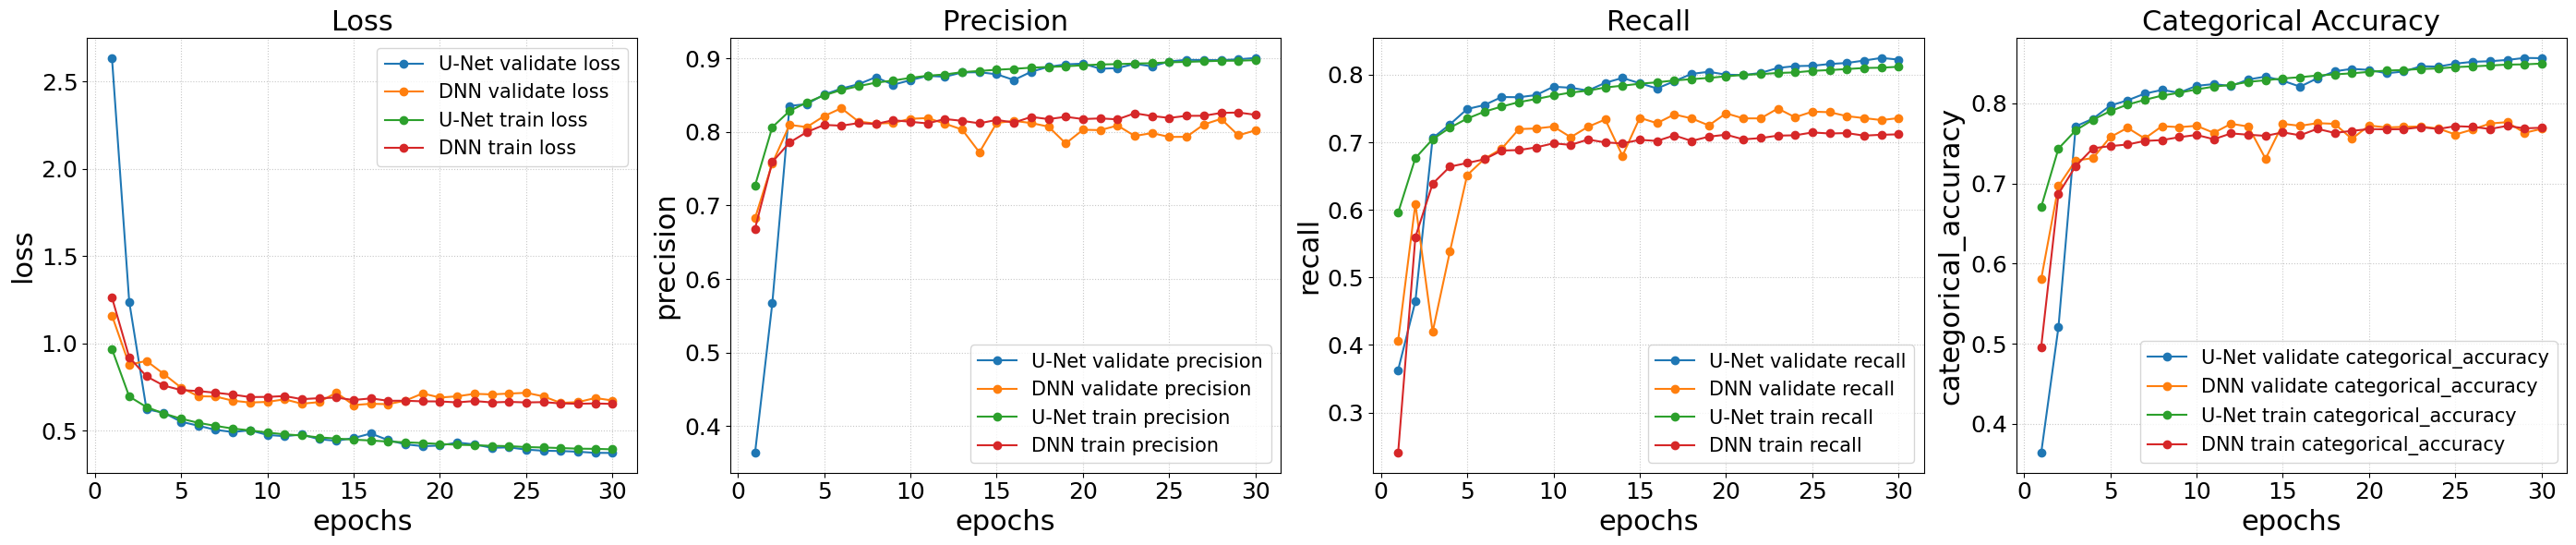

In [52]:
# Create subplots for different metrics in a 3x4 grid
fig, axs = plt.subplots(1, 4, figsize=(4*7, 6*1))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
metrics = ["loss", "precision", "recall", "categorical_accuracy"]
metrics_name = ["Loss", "Precision", "Recall", "Categorical Accuracy"]

epochs = range(1, config.EPOCHS + 1)

title_fontsize = 22
label_fontsize = 22
legend_fontsize = 15
tick_fontsize = 18
lw=1.5

for y in range(len(metrics)):
    axs[y].plot(epochs, unet_model_metrics[f"val_{metrics[y]}"], color=colors[0], marker="o", lw=lw, label=f"U-Net validate {metrics[y]}")
    axs[y].plot(epochs, dnn_model_metrics[f"val_{metrics[y]}"], color=colors[1], lw=lw, marker="o", label=f"DNN validate {metrics[y]}")

    axs[y].plot(epochs, unet_model_metrics[metrics[y]], color=colors[2], lw=lw, marker="o", label=f"U-Net train {metrics[y]}")
    axs[y].plot(epochs, dnn_model_metrics[metrics[y]], color=colors[3], lw=lw, marker="o", label=f"DNN train {metrics[y]}")
    axs[y].set_title(f"{metrics_name[y]}", fontsize=title_fontsize)
    axs[y].set_xlabel("epochs", fontsize=label_fontsize)
    axs[y].set_ylabel(f"{metrics[y]}", fontsize=label_fontsize)
    axs[y].grid(linestyle="dotted", alpha=0.7)
    axs[y].legend(fontsize=legend_fontsize)
    axs[y].tick_params(axis="both", which="major", labelsize=tick_fontsize)


# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("metrics_plot_model_comparison.png", dpi=500, bbox_inches="tight")
plt.show()


### Probability Distribution Plot

In [53]:
all_data = {}

unet_data = []
dnn_data = []

unet_rice_data = []
dnn_rice_data = []

unet_other_data = []
dnn_other_data = []

for i, feature in enumerate(prob_output_unet["features"]):
    unet_rice_prob = round(feature["properties"]["rice_prob"], 5)
    unet_other_prob = round(feature["properties"]["cropland_prob"] + round(feature["properties"]["forest_prob"] + feature["properties"]["others_prob"]+ feature["properties"]["urban_prob"]), 5)
    unet_data.append([unet_rice_prob, unet_other_prob])
    unet_rice_data.append(unet_rice_prob)
    unet_other_data.append(unet_other_prob)

    dnn_feature = prob_output_dnn["features"][i]
    dnn_rice_prob = round(dnn_feature["properties"]["rice_prob"], 5)
    dnn_other_prob = 1. - round(dnn_feature["properties"]["rice_prob"], 5)
    # dnn_other_prob = round(dnn_feature["properties"]["cropland_prob"] + dnn_feature["properties"]["forest_prob"] + dnn_feature["properties"]["others_prob"]+ dnn_feature["properties"]["urban_prob"], 5)
    dnn_data.append([dnn_rice_prob, dnn_other_prob])
    dnn_rice_data.append(dnn_rice_prob)
    dnn_other_data.append(dnn_other_prob)


Text(0.5, 1.0, 'Other Probability')

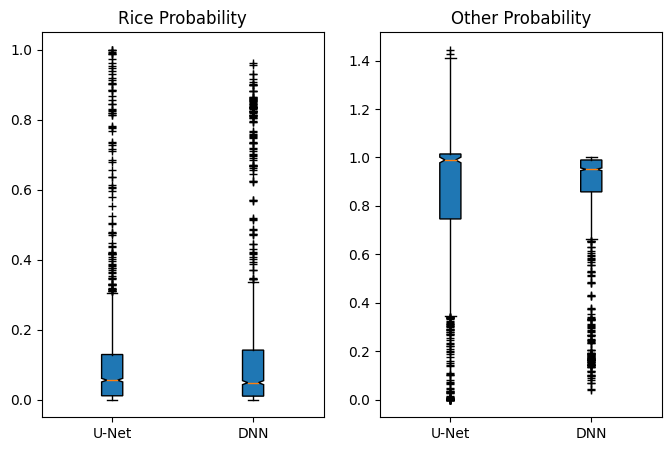

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

title_fontsize = 22
label_fontsize = 10
tick_fontsize = 10

# rectangular box plot
bplot1 = ax1.boxplot([unet_rice_data, dnn_rice_data],
                     notch=True,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=["U-Net", "DNN"],
                     sym="k+")  # will be used to label x-ticks
ax1.set_title("Rice Probability")

# notch shape box plot
bplot2 = ax2.boxplot([unet_other_data, dnn_other_data],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=["U-Net", "DNN"],
                     sym="k+")  # will be used to label x-ticks
ax2.set_title("Other Probability")
